# 1. Изучение данных

**Основная задача:** помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Этапы достижения основной задачи:
- определить продуктовые метрики,
- определить метрики электронной коммерции,
- определить маркетинговые метрики.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

Структура **visits**:
- **Uid** — уникальный идентификатор пользователя,
- **Device** — категория устройства пользователя,
- **Start Ts** — дата и время начала сессии,
- **End Ts** — дата и время окончания сессии,
- **Source Id** — идентификатор источника перехода на сайт.

Структура **orders**:
- **Uid** — уникальный идентификатор пользователя,
- **Buy Ts** — дата и время заказа,
- **Revenue** — сумма заказа.

Структура **costs**:
- **source_id** — идентификатор рекламного источника,
- **dt** — дата проведения рекламной кампании,
- **costs** — расходы на эту кампанию.

Приведем названия столбцов в каждом DF к общему стандарту:

In [3]:
visits.rename(
    columns = {'Device':'device', 'End Ts':'end_ts', 'Source Id':'source_id','Start Ts':'start_ts', 'Uid':'uid'}, inplace = True)
orders.rename(
    columns = {'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'}, inplace = True)

Используя код из ранее сделанных проектов, сведем информацию о всех DF в одну сводную таблицу:

In [4]:
# Создадим словарь соответствия фрейма и его имени
dict_frames ={
    'visits': visits,
    'orders': orders,
    'costs': costs,
}

In [5]:
# Функция, для сбора информации о всех DF
def info_frame(dict_of_frames):
    def table(dataframe, name):
        # Собираем данные из конкретной таблицы
        columns = dataframe.columns
        count_of_rows = len(columns)
        total = dataframe.shape[0]

        part_total_table = pd.DataFrame(data=[[0] * 5] * count_of_rows,
                                        columns=['total',
                                                 'frame',
                                                 "columns",
                                                 "null_values",
                                                 "type"])

        part_total_table['total'] = [total] * count_of_rows
        part_total_table['frame'] = [name] * count_of_rows
        part_total_table['columns'] = columns

        for column in columns:
            curent_type = str(dataframe[column].dtype)
            count_of_null = dataframe[column].isnull(
            ).sum() * 100 / part_total_table['total']
            part_total_table.loc[part_total_table['columns']
                                 == column, 'null_values'] = count_of_null
            part_total_table.loc[part_total_table['columns']
                                 == column, 'type'] = curent_type

        return part_total_table

    # объединяем даные из каждой таблицы в одну
    final_frame = pd.DataFrame(
        columns=['total', 'frame', "columns", "null_values", "type"])

    for name, frame in dict_of_frames.items():
        part_of_table = table(frame, name)
        final_frame = final_frame.append(part_of_table)

    final_frame = final_frame.reset_index(drop=True)
    final_frame_grouped = final_frame.groupby(
        ['total', 'frame', "columns"]).first()
    final_frame_grouped = final_frame_grouped.style.background_gradient(
        cmap='Blues', subset=['null_values'])

    return final_frame_grouped

Необходимо перевести временные данные в соответсвующий тип:

In [6]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

Для оптимизации изменим тип int64 на int8:

In [7]:
costs['source_id'] = costs['source_id'].astype('int8')
visits['source_id'] = visits['source_id'].astype('int8')
visits['device'] = visits['device'].astype('category')

Выполним проверку и удаление дубликатов в каждом DF:

In [8]:
costs = costs.drop_duplicates().reset_index(drop = True)
orders = orders.drop_duplicates().reset_index(drop = True)
visits = visits.drop_duplicates().reset_index(drop = True)

In [9]:
info_frame(dict_frames)

**Вывод:** Пустых значений нет ни в одном DF. Дубликатов нет. Все данные соотвествуют необходимому типу. Исследуемый интервал периода времени с 2017-06-01 по 2018-05-31.

## 2. Продуктовые метрики

### 2.1. DAU, WAU, MAU

Определим год, месяц, неделю посещения:

In [10]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype(
    'datetime64[M]').dt.strftime('%Y-%m')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date

Вычислим средние значения каждой метрики:

In [11]:
mau_mean = visits.groupby(['session_year', 'session_month']).agg(
    {'uid': 'nunique'}).mean()
dau_mean = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_mean = (visits.groupby(['session_year', 'session_week'])
            .agg({'uid': 'nunique', 'session_date': 'nunique'})
            .query('session_date == 7'))['uid'].mean()
param = pd.DataFrame(
    {'MAU': mau_mean, 'DAU': dau_mean, 'WAU': wau_mean}).round(1)
param

,MAU,DAU,WAU
uid,23228.4,908.0,5811.0


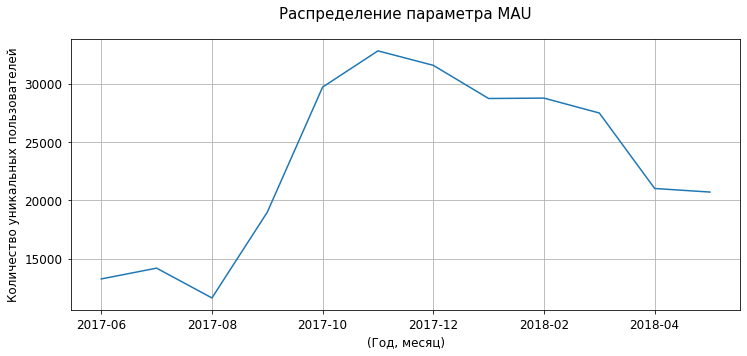

In [12]:
mau = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
mau = mau.reset_index()[['session_month', 'uid']]
mau.plot(figsize=(12, 5), grid=True, x='session_month')
plt.title('Распределение параметра MAU', fontsize=15, pad=20)
plt.xlabel('(Год, месяц)', fontsize=12)
plt.ylabel('Количество уникальных пользователей', fontsize=12)
plt.legend().remove()
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=5,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

In [13]:
mau[mau['uid'] == mau['uid'].max()]

,session_month,uid
5,2017-11,32797


**Вывод**: Из распределния MAU видно, что максимальное количество новых пользователей было в ноябре 2017г., минимальное соответсвует августу 2017 г.

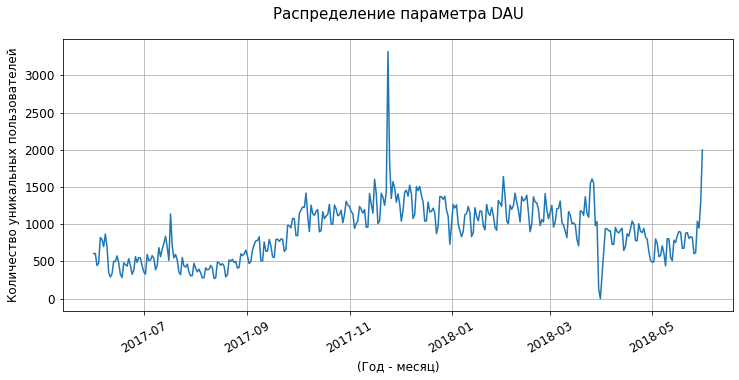

In [14]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'})
dau.plot(figsize=(12, 5), grid=True)
plt.title('Распределение параметра DAU', fontsize=15, pad=20)
plt.xlabel('(Год - месяц)', fontsize=12)
plt.ylabel('Количество уникальных пользователей', fontsize=12)
plt.xticks(rotation=30)
plt.legend().remove()
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=5,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

In [15]:
dau[dau['uid'] == dau['uid'].max()]

,uid
session_date,
2017-11-24,3319


**Вывод**: Из распределния DAU видно, что максимальное количество новых пользователей было 24 ноября 2017г., минимальное соответсвует 31 марта 2018 г. Есть предположение, что в день макисмально новых пользвателей была суточная реклама. Потому что резкий скачок также резко упал к стандартным значениям.  

In [16]:
wau = (visits.groupby(['session_year', 'session_week'])
       .agg({'uid': 'nunique', 'session_date': 'nunique'})
       .query('session_date == 7')
       )
wau.reset_index(inplace=True)

Text(50, -30, 'Черная пятница')

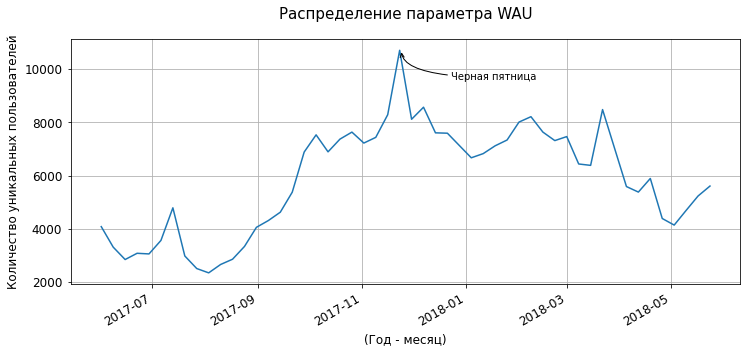

In [17]:
wau.plot(figsize=(12, 5), grid=True, y='uid', x='session_week')
plt.title('Распределение параметра WAU', fontsize=15, pad=20)
plt.axes = ''
plt.xlabel('(Год - месяц)', fontsize=12)
plt.ylabel('Количество уникальных пользователей', fontsize=12)
plt.xticks(rotation=30)
plt.legend().remove()
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=5,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)
plt.annotate("Черная пятница", xy=('2017-11-24', 10716),  xycoords='data',
             xytext=(50, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="angle3,angleA=0,angleB=-90", color="#000000"))

In [18]:
wau[wau['uid'] == wau['uid'].max()][['session_week','uid']]

,session_week,uid
25,2017-11-23,10716


**Вывод**: Из распределния WAU видно, что максимальное количество новых пользователей было 23 ноября 2017г., перед "Черной пятницей", которое превышает в два раза средне-арифмитическое значение (5811) за весь исследуемый период.

## 2.2. Среднее количество посещений 

In [19]:
visits_in_day_mean = round(visits.groupby('session_date')['uid'].count().mean(), 2)
print('Среднее количество посещений сайта в день:', visits_in_day_mean)

Среднее количество посещений сайта в день: 987.36


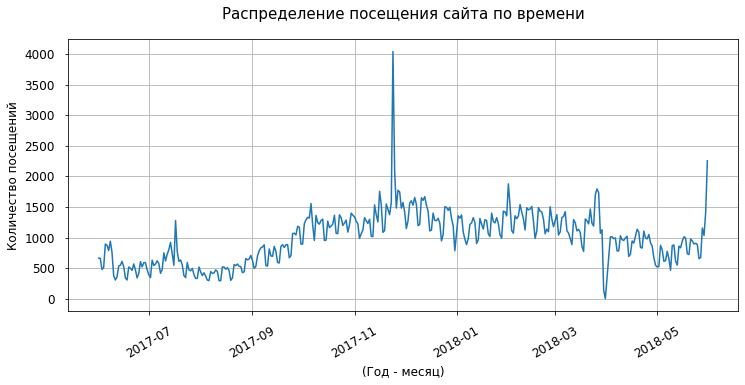

In [20]:
visits_in_day = visits.groupby('session_date').agg({'uid': 'count'})
visits_in_day.plot(figsize=(12, 5), grid=True)
plt.title('Распределение посещения сайта по времени', fontsize=15, pad=20)
plt.xlabel('(Год - месяц)', fontsize=12)
plt.xticks(rotation=30)
plt.ylabel('Количество посещений', fontsize=12)
plt.legend().remove()
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=10,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

In [21]:
visits_in_day[visits_in_day['uid'] == visits_in_day['uid'].max()]

,uid
session_date,
2017-11-24,4042


**Вывод**: Из распределния посещений сайта видно, что максимальное количество новых пользователей было 24 ноября 2017г., что соответсвует дате максимальному колмчеству новых пользователей. Кажется, что в этот день был использван новый инстумент маркетинга. 

##  2.3. Время нахождения на сайте

In [22]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()
asl = visits['session_duration_sec'].mode().round(1)
print('Наиболее распространенное значение нахождения на сайте(c) =', asl[0])

Наиболее распространенное значение нахождения на сайте(c) = 60.0


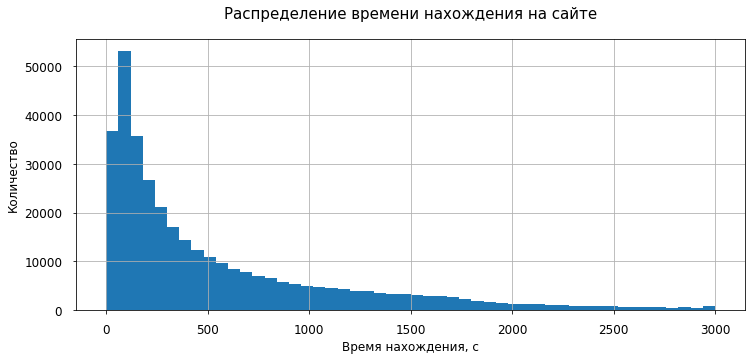

In [23]:
visits['session_duration_sec'].hist(bins=50, range=(0, 3000), figsize=(12, 5))
plt.title('Распределение времени нахождения на сайте', fontsize=15, pad=20)
plt.xlabel('Время нахождения, с', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=10,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

**Вывод**: Из распределния видно, что наиболее распространенное время нахождения на сайте составляет 1 минуту. 

## 2.4. Retention Rate

In [24]:
visits['start'] = pd.to_datetime(visits['start_ts'].dt.normalize())

Определим первое посещение каждого пользователя:

In [25]:
first_activity_date = visits.groupby(['uid'])['start'].min()
first_activity_date.name = 'first_activity_date'

Добавим в общую таблицу данные о первом посещении для каждого пользователя:

In [26]:
visits = visits.join(first_activity_date, on='uid')

Так как когорты будем формировать по месяцам, то приведем каждое посещение к началу месяца: 

In [27]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['start'].astype('datetime64[M]')

Определим время жизни каждого посещения, относительно первого посещения:

In [28]:
visits['cohort_lifetime'] = (visits['activity_month'] - visits['first_activity_month'])

Приведем к числовому значению и выделим целую часть:

In [29]:
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Cформируем когорту:

In [30]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Построим когорту и сделаем срез с нулевыми значениями длины жизни:

In [31]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Объединим данные:

In [32]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

Рассчитаем **Retention Rate**, разделив количество активных пользователей в каждый месяц на исходное число пользователей в когорте:

In [33]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [34]:
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')

In [35]:
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

Визуализируем полученные результаты:

<AxesSubplot:title={'center':'Retention Rate'}, xlabel='cohort_lifetime', ylabel='first_activity_month'>

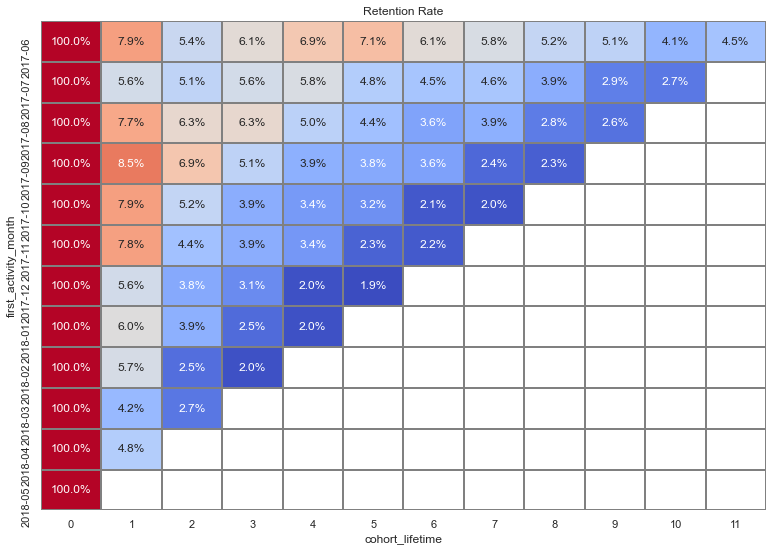

In [36]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1,
            linecolor='gray', cmap='coolwarm', cbar=False, vmax=0.1)

Рассчитаем средний Retention Rate на втором месяце жизни когорт:

In [37]:
RR_mean_2month = retention_pivot[1].mean()
print("""Средний Retention Rate на втором месяце жизни = {:.3%}""".format(RR_mean_2month))

Средний Retention Rate на втором месяце жизни = 6.517%


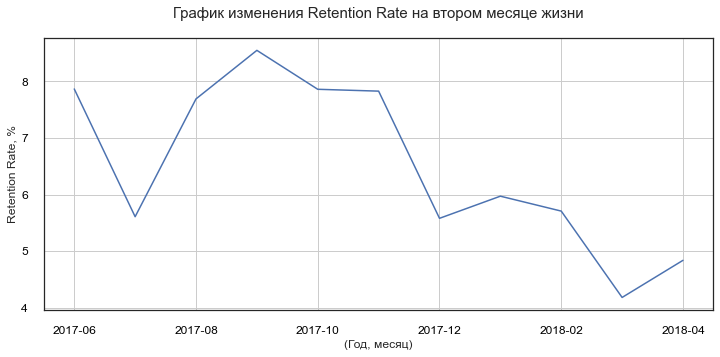

In [38]:
RR_2month = retention_pivot[1]*100
RR_2month.plot(figsize=(12, 5), grid=True)
plt.title('График изменения Retention Rate на втором месяце жизни',
          fontsize=15, pad=20)
plt.xlabel('(Год, месяц)', fontsize=12)
plt.ylabel('Retention Rate, %', fontsize=12)
plt.legend().remove()
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=10,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

**Вывод**: Из распределния видно, что на втором месяце жизни когорот Retention Rate самый высокий у пользователей, пришедших в сентябре. С каждой последующей когортой Retention Rate падает. Возможно выбран не тот источник трафика. 

# 3. Метрики электронной коммерции

## 3.1. Время с первого посещения до покупки

Обьединим две таблица по столбцу **uid** и выберем необходимые данные для рассчета:

In [39]:
visits_orders = orders.merge(visits, how='left', on='uid')
visits_orders_part = visits_orders[['uid', 'buy_ts', 'start_ts']]

Заново определим для каждого пользователя время его первого посещения и занесем данные в общую таблицу:

In [40]:
visits_orders_first_activity = visits_orders_part.groupby(['uid'])['start_ts'].min()
visits_orders_first_activity.name = 'visits_orders_first_activity'
visits_orders_part = visits_orders_part.join(
    visits_orders_first_activity, on='uid')

Определим разницу с момента первого посещения до покупки 

In [41]:
visits_orders_part['delta_time'] = visits_orders_part['buy_ts'] - \
    visits_orders_part['visits_orders_first_activity']

Сгрупперуем данные по пользователям и найдем первую покупку:

In [42]:
visits_orders_pivot = visits_orders_part.groupby('uid').agg({'delta_time': 'min'}).reset_index()
visits_orders_pivot['delta_time'] = visits_orders_pivot['delta_time'].dt.seconds.div(
    60).astype(int)
visits_orders_pivot['delta_time'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: delta_time, dtype: float64

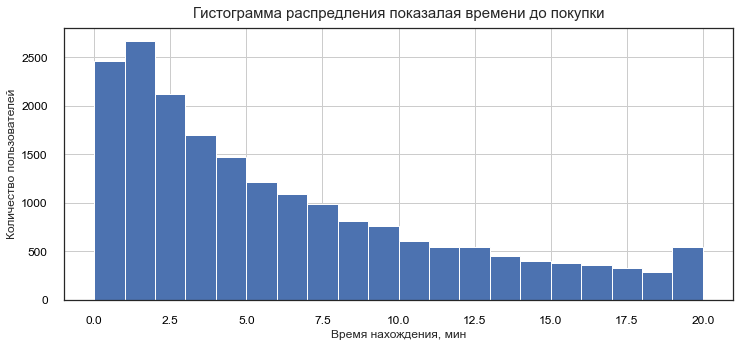

In [43]:
visits_orders_pivot['delta_time'].hist(bins=20, figsize=(12, 5), range=(0, 20))
plt.title('Гистограмма распредления показалая времени до покупки',
          fontsize=15, pad=10)
plt.xlabel('Время нахождения, мин', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=10,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

**Вывод**: Медианное время  с момента первого посещения до покупки составляет 16 минут, что является более достоверным значением, чем средне-арифметическое.

## 3.2. Среднее количество покупок на одного покупателя за определенный период

Создадим столбец с годом и месяцем покупки:

In [44]:
orders['period'] = orders['buy_ts'].astype('datetime64[M]')

Выполним индексацию по столбцу **uid**

In [45]:
orders.set_index('uid', inplace=True)

Сгруперуем по первому столбцу (**uid**) и найдем первую покупку у каждого пользователя:

In [46]:
orders['cohort_group'] = orders.groupby(
    level=0)['buy_ts'].min().astype('datetime64[M]')
orders.reset_index(inplace=True)

Сгрупперуем данные и выполним агрегирование: посчитаем количество уникальных покупателей в каждом периоде в каждой когорте и посчитаем общее количество покупку за этот же период:

In [47]:
grouped = orders.groupby(['cohort_group', 'period'])
cohorts = grouped.agg({'uid': 'nunique',
                       'revenue': 'count'})
cohorts.rename(columns={'uid': 'total_clients',
                        'revenue': 'total_orders'}, inplace=True)

Проиндексируем каждую когорту по месяца, это позволяет нам сравнивать когорты на разных этапах их жизни:

In [48]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    df['count_orders'] = df['total_orders'] / df['total_clients'][0]
    return df


cohorts = cohorts.groupby(level=0).apply(cohort_period)

Определим среднее количество покупок на каждом этапе:

In [49]:
orders_pivot = cohorts.pivot_table(
    index='cohort_group',
    columns='cohort_period',
    values='count_orders',
    aggfunc='sum',
)
orders_pivot = orders_pivot.cumsum(axis=1)
orders_pivot.index = orders_pivot.index.strftime("%m/%Y")

Визуализируем полученные результаты - среднее количество покупок на одного покупателя:

<AxesSubplot:title={'center':'Среднее количество покупок на одного покупателя'}, xlabel='cohort_period', ylabel='cohort_group'>

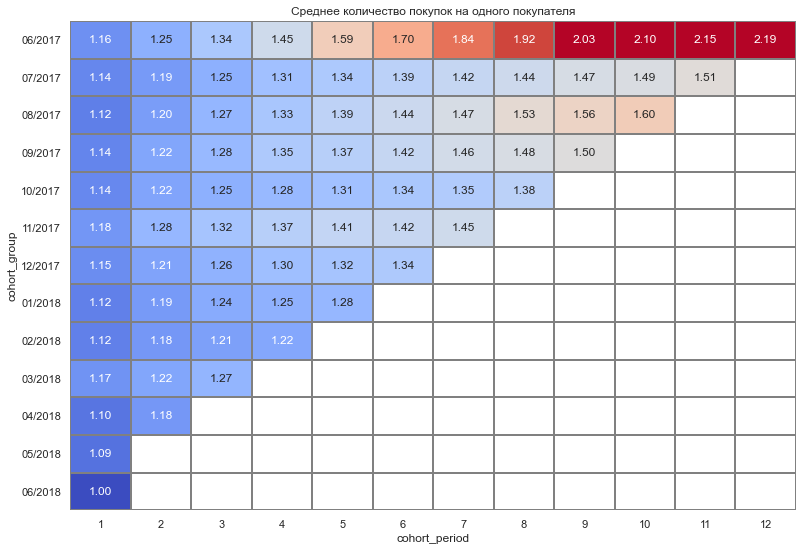

In [50]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Среднее количество покупок на одного покупателя')
sns.heatmap(orders_pivot, annot=True, fmt='.2f', linewidths=1,
            linecolor='gray', cmap='coolwarm', cbar=False, vmax=2)

In [51]:
order_mean = orders_pivot[6].mean()
order_mean
print('Среднее количество покупок на одного человека за 6 месяцев = {:.3f}'.format(
    order_mean))

Среднее количество покупок на одного человека за 6 месяцев = 1.434


**Вывод**: Мы определили, что среднеарифмитическое значение покупок на одного человека за 6 месяцев, составляет 1.434.

## 3.3. Средний чек

Средний чек определим путем суммирования стоимости всех покупок, деленное на количество покупок:

In [52]:
price_mean_group = orders.groupby('period').agg({'revenue': 'sum',
                                                 'uid': 'count'})
price_mean_group.rename(
    columns={'uid': 'total_ord', 'revenue': 'sum_ord'}, inplace=True)
price_mean_group['price_mean'] = (
    price_mean_group['sum_ord'] / price_mean_group['total_ord']).round(2)

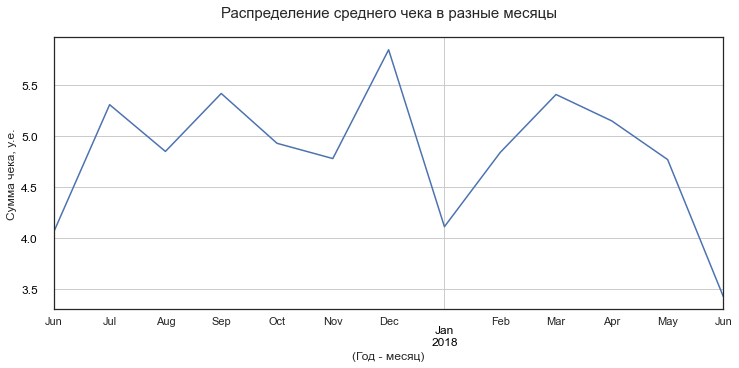

In [53]:
price_mean_group['price_mean'].plot(figsize=(12, 5), grid=True)
plt.title('Распределение среднего чека в разные месяцы', fontsize=15, pad=20)
plt.xlabel('(Год - месяц)', fontsize=12)
plt.ylabel('Сумма чека, у.е.', fontsize=12)
plt.legend().remove()
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=10,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

In [54]:
price_mean_group[price_mean_group['price_mean'] == price_mean_group['price_mean'].max()]

,sum_ord,total_ord,price_mean
period,,,
2017-12-01,36388.6,6218,5.85


**Вывод**: Самый большой средний чек был в декабре и составил 5.85 у.е. Возможно это связано с наступлением новогодних праздников.

## 3.3. LTV

Определим количество новых покупателей в каждой кагорте:

In [55]:
cohort_sizes = (
    orders.groupby('cohort_group')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['cohort_group', 'n_buyers']

Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку:

In [56]:
cohorts_orders = (
    orders.groupby(['cohort_group', 'period'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

Добавим в таблицу cohorts_orders данные о том, сколько людей первый раз совершили покупку в каждый месяц

In [57]:
report = pd.merge(cohort_sizes, cohorts_orders, on='cohort_group')

Поскольку моржинальность 100%, то валовая прибыль = выручки. Также определим возраст когорты и выберем когорты с возрастом от 6 месяцев:

In [58]:
def cohort_period(df):
    if len(df) >= 6:
        df['cohort_period'] = np.arange(len(df)) + 1
        return df

report = report.groupby('cohort_group').apply(cohort_period)
report.reset_index(drop=True, inplace=True)

Рассчитаем LTV:

In [59]:
report['ltv'] = report['revenue'] / report['n_buyers']

Для наглядности выведем значения LTV в сводную таблицу и визуализируем:

In [60]:
output = report.pivot_table(
    index='cohort_group', columns='cohort_period', values='ltv', aggfunc='sum')
output = output.cumsum(axis=1)
output.index = output.index.strftime("%m/%Y")

<AxesSubplot:title={'center':'LTV'}, xlabel='cohort_period', ylabel='cohort_group'>

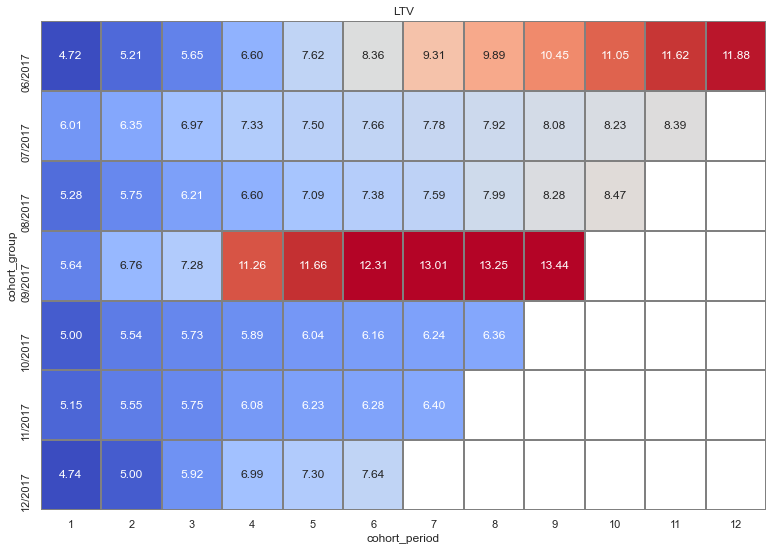

In [61]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap='coolwarm', cbar=False, vmax=12)

In [62]:
total_output = round(output.loc[:,0:6].mean(), 2)

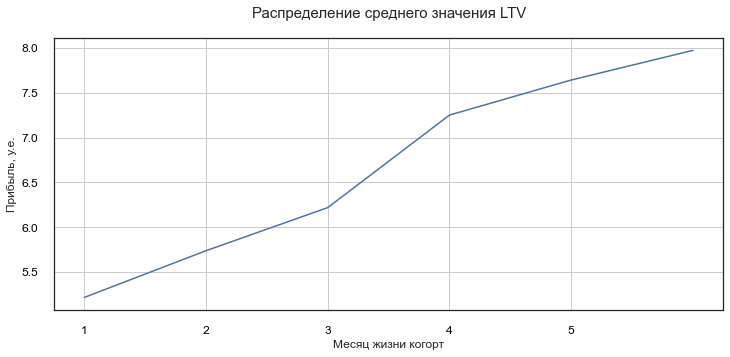

In [63]:
total_output.plot(figsize=(12, 5), grid=True)
plt.title('Распределение среднего значения LTV', fontsize=15, pad=20)
plt.xlabel('Месяц жизни когорт', fontsize=12)
plt.ylabel('Прибыль, у.е.', fontsize=12)
plt.legend().remove()
plt.xticks(range(1, 6, 1))
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=10,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

**Вывод:** LTV - это прибыль компании, полученная от одного клиента за всё время сотрудничества с ним. По тепловой карте можно сказать, что клиенты, пришедшие впервые в 2017-09 уже на третем месяце резко увеличили свою прибыль компании.  

# 4. Маркетинговые метрики

## 4.1. Общая сумма расходов. Траты по источникам

Приведем дату проведения рекламной кампании к исследуемому виду:

In [64]:
costs['period'] = costs['dt'].astype('datetime64[M]')

In [65]:
costs_group = costs.groupby('period').agg({'costs': 'sum'})

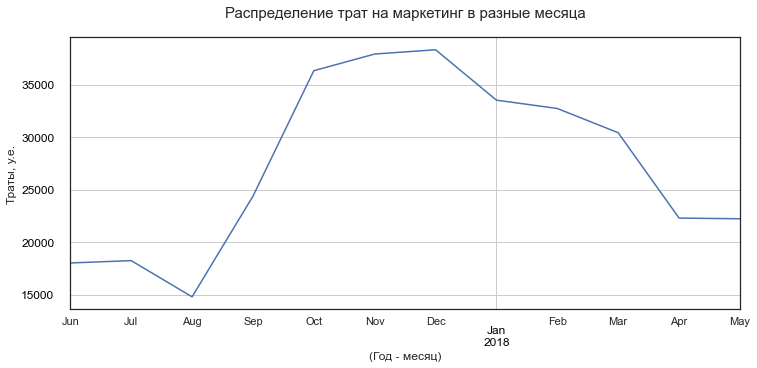

In [66]:
costs_group.plot(figsize=(12, 5), grid=True)
plt.title('Распределение трат на маркетинг в разные месяца', fontsize=15, pad=20)
plt.xlabel('(Год - месяц)', fontsize=12)
plt.ylabel('Траты, у.е.', fontsize=12)
plt.legend().remove()
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=10,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

**Вывод:** С октября по декабрь 2017 года маркетологи потратили больше всего за весь исследуемый период.

In [67]:
total_cost = costs['costs'].sum()
print('Общая сумма потраченная на маркетинг = {:.0f} у.е.'.format(total_cost))

Общая сумма потраченная на маркетинг = 329132 у.е.


In [68]:
costs_source = costs.pivot_table(index='period', columns='source_id', values='costs', aggfunc='sum')

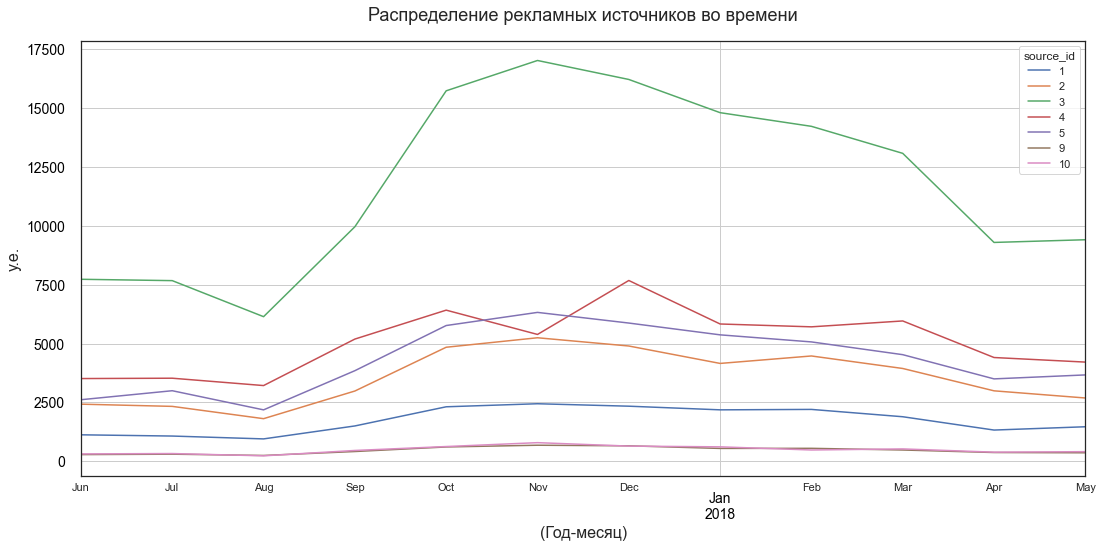

In [69]:
costs_source.plot(figsize=(18, 8), grid=True)
plt.title('Распределение рекламных источников во времени', fontsize=18, pad=20)
plt.xlabel('(Год-месяц)', fontsize=16)
plt.ylabel('у.е.', fontsize=16)
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=10,  # Расстояние между черточкой и ее подписью
    labelsize=14,  # Размер подписи
    labelcolor='#000000'
)

**Вывод:** 3 источник рекламы оказался с самым большим бюджетом.

## 4.2. САС и ROI

In [70]:
costs_month = (
    costs.groupby('period')
    .agg({'costs': 'sum'})
    .reset_index()
)
costs_month.columns = ['cohort_group', 'cost']

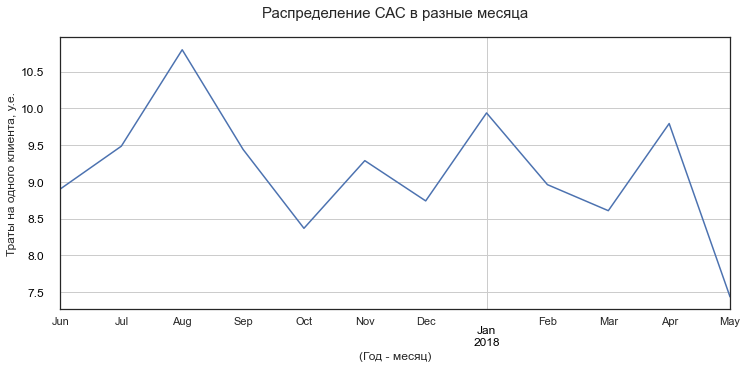

In [71]:
orders_costs = cohort_sizes.merge(costs_month, on='cohort_group')
orders_costs['cac'] = orders_costs['cost'] / orders_costs['n_buyers']
orders_costs.set_index('cohort_group', inplace=True)
orders_costs['cac'].plot(figsize=(12, 5), grid=True)
plt.title('Распределение САС в разные месяца', fontsize=15, pad=20)
plt.xlabel('(Год - месяц)', fontsize=12)
plt.ylabel('Траты на одного клиента, у.е.', fontsize=12)
plt.legend().remove()
plt.tick_params(
    axis='both',  # Применяем параметры к обеим осям
    pad=10,  # Расстояние между черточкой и ее подписью
    labelsize=12,  # Размер подписи
    labelcolor='#000000'
)

**Вывод:** В августе 2017г. для компании привлечение клиента стало самым дорогим. 

Построим распределние САС по источникам трафика:

In [72]:
first_source = (visits
                .sort_values(by=['uid', 'start_ts'])
                .groupby('uid').agg({'start_ts': 'first',
                                     'source_id': 'first'}
                                    )
                .reset_index()
                )
first_source.columns = ['uid', 'first_activity_month', 'source_id']

Присоединяем таблицу с рассходами по источнику и дате первого использования этого источника:

In [73]:
new_orders = pd.merge(orders, first_source, on='uid').reset_index()

In [74]:
first_order_month = new_orders.groupby('uid')['buy_ts'].min().astype('datetime64[M]')
first_order_month.name = 'first_order_month'
new_orders = new_orders.join(first_order_month, on='uid')
new_orders['order_month'] = new_orders['buy_ts'].astype('datetime64[M]')

In [75]:
source_cohort_sizes = (new_orders
                       .groupby(['source_id', 'first_order_month'])
                       .agg({'uid': 'nunique'})
                       .reset_index()
                       )
source_cohort_sizes.rename(columns={'uid': 'source_n_buyers'}, inplace=True)

Определим выручку по когортам на разном этапе жизни:

In [76]:
revenue_by_sources = (new_orders
                      .groupby(['first_order_month', 'order_month', 'source_id'])
                      .agg({'revenue': 'sum'})
                      .reset_index())

In [77]:
report_source = revenue_by_sources.merge(source_cohort_sizes, on=['first_order_month', 'source_id'])

Определим затраты на маркетинг:

In [78]:
costs_for_source = (costs
                    .groupby(['source_id', 'period'])
                    .agg({'costs': 'sum'})
                    .reset_index())

In [79]:
romi_report_source = report_source.merge(costs_for_source, left_on=['first_order_month', 'source_id'],
                                         right_on=['period', 'source_id'])

Определим возраст каждой когорты:

In [80]:
romi_report_source['age'] = (romi_report_source['order_month'] - romi_report_source['first_order_month'])
romi_report_source['age'] = romi_report_source['age'] / np.timedelta64(1, 'M')
romi_report_source['age'] = romi_report_source['age'].round().astype('int') + 1

Определим метрики LTV, CAC, ROI:

In [81]:
romi_report_source['ltv'] = romi_report_source['revenue'] / \
    romi_report_source['source_n_buyers']
romi_report_source['cac'] = romi_report_source['costs'] / \
    romi_report_source['source_n_buyers']
romi_report_source['roi'] = romi_report_source['ltv'] / \
    romi_report_source['cac']

По каждому источнику определим LTV и ROI:

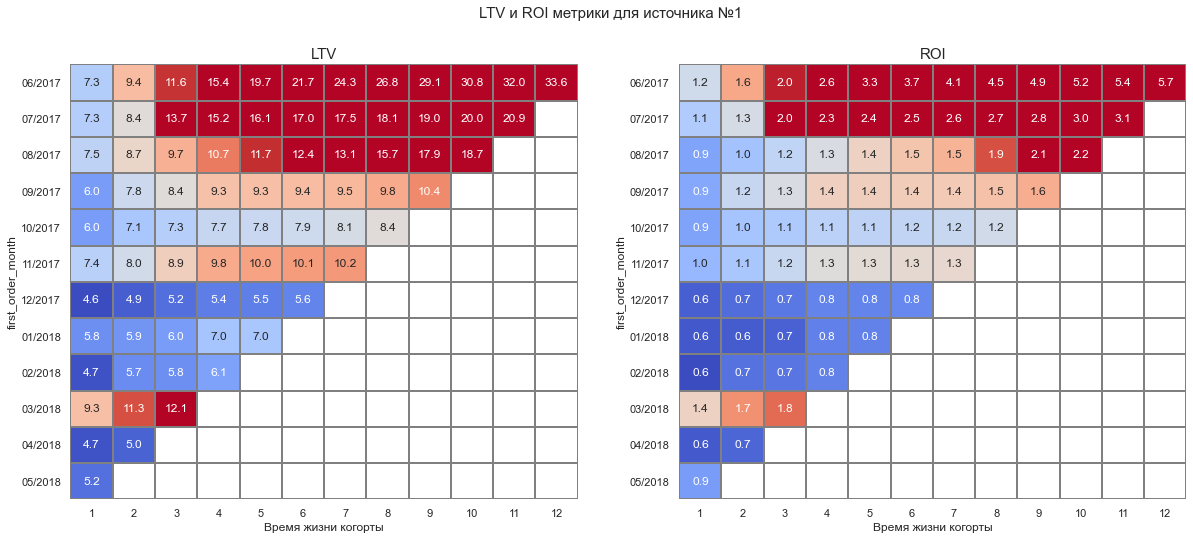

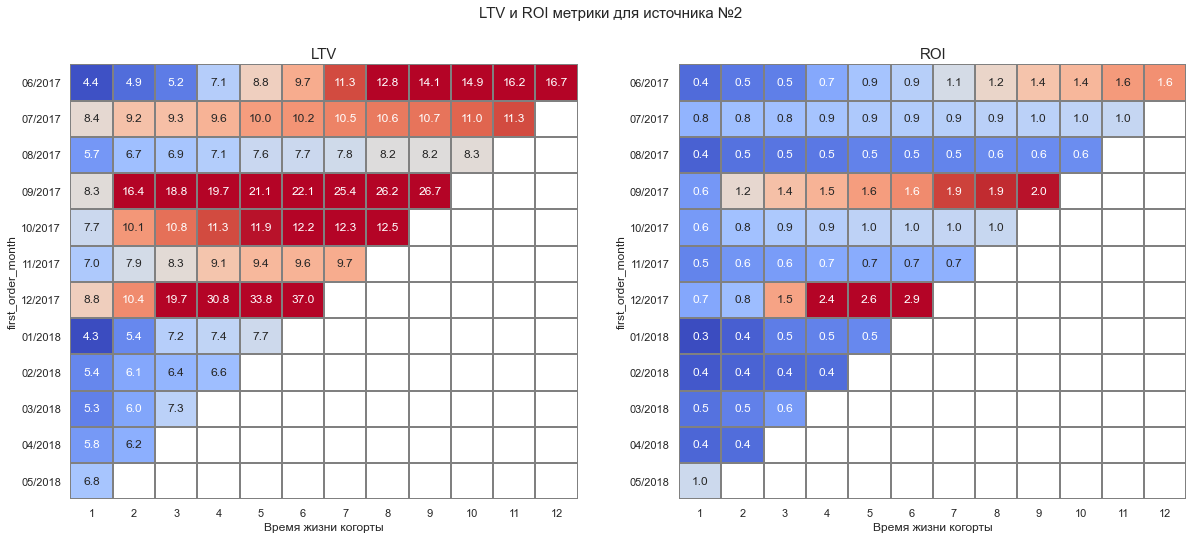

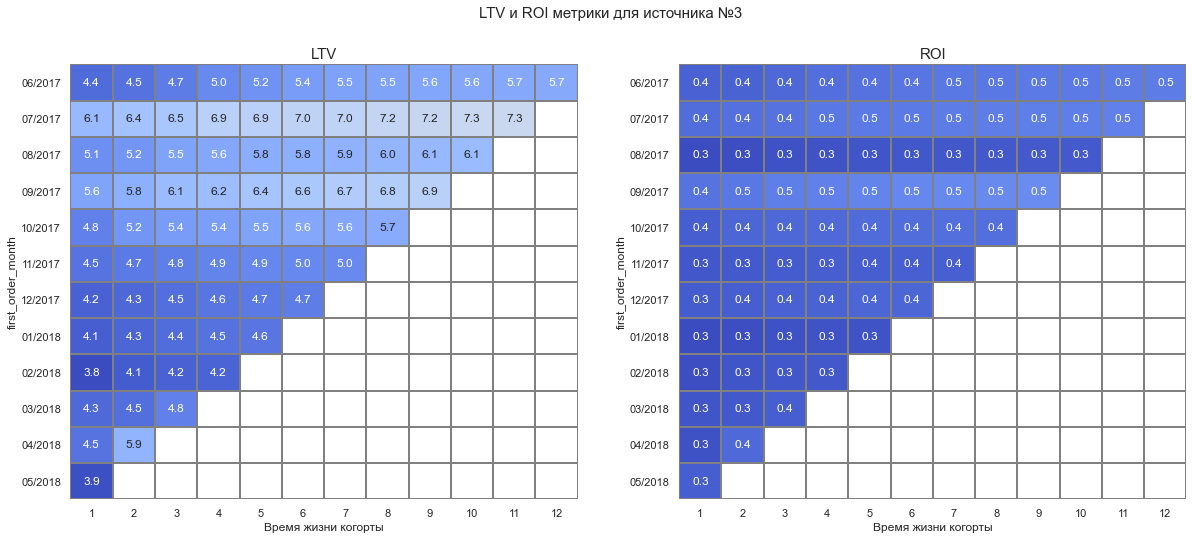

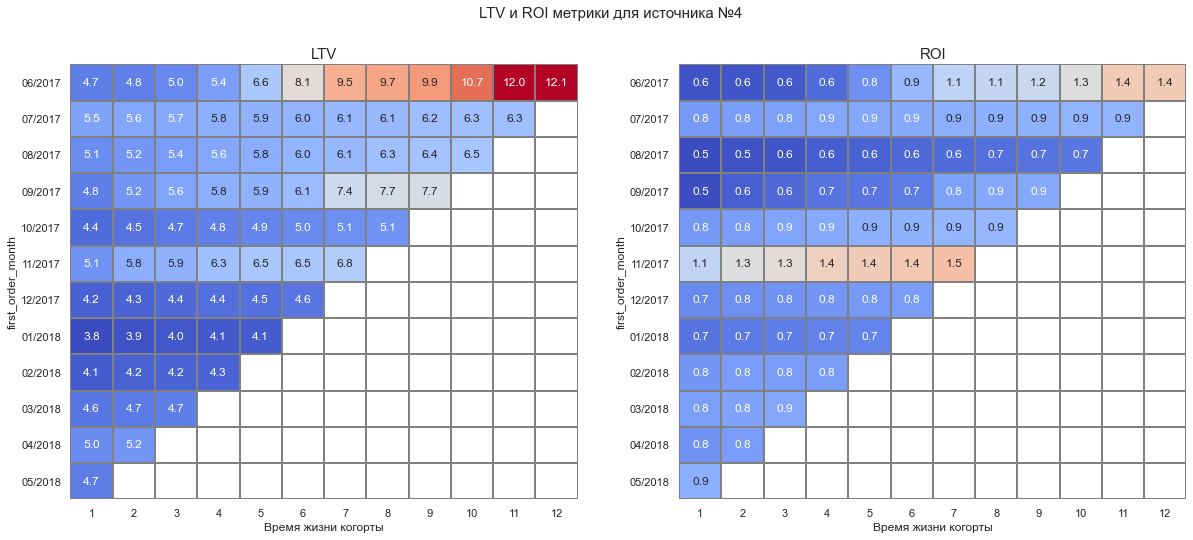

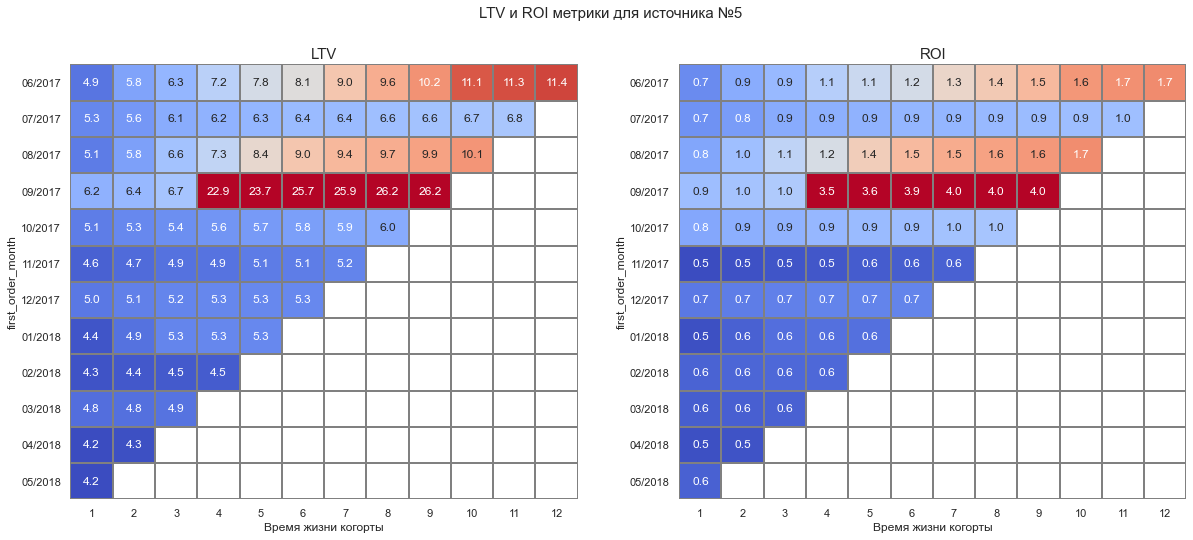

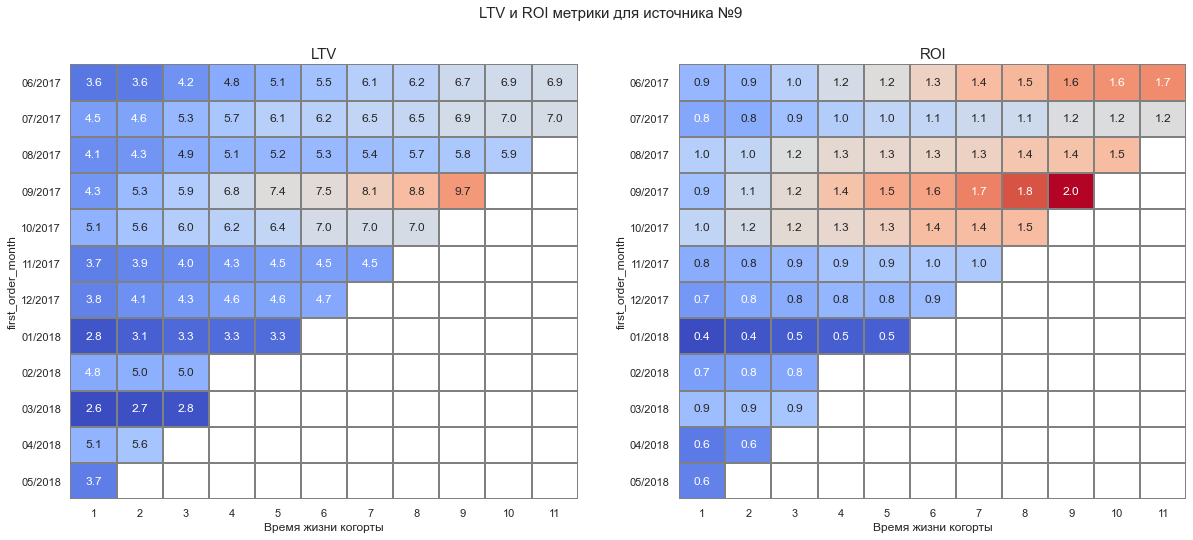

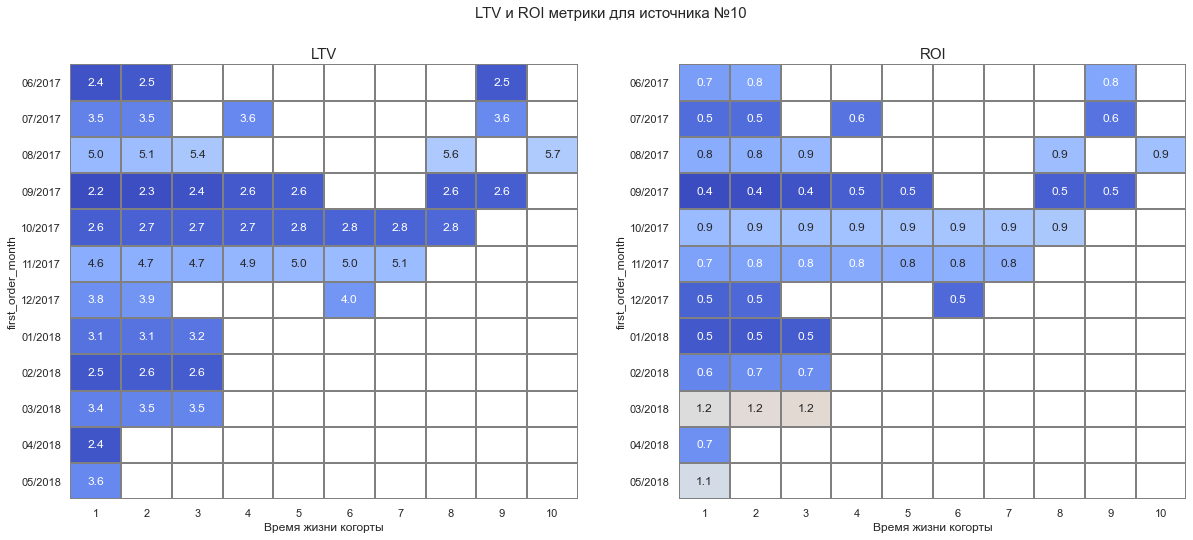

In [82]:
list_sorce = romi_report_source['source_id'].unique()
for i in list_sorce:

    df = romi_report_source.copy().query('source_id == @i')

    # подготовим данные для тепловой карты по LTV:
    ltv = df.pivot_table(index='first_order_month',
                         columns='age', values='ltv', aggfunc='mean')
    ltv = ltv.cumsum(axis=1)
    ltv.index = ltv.index.strftime("%m/%Y")

    # подготовим данные для тепловой карты по ROI:
    roi = df.pivot_table(index='first_order_month',
                         columns='age', values='roi', aggfunc='mean')
    roi = roi.cumsum(axis=1)
    roi.index = roi.index.strftime("%m/%Y")

    # выведем тепловые карты
    tit = 'LTV и ROI метрики для источника №' + str(i)
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(tit, fontsize=15)
    sns.heatmap(ltv, annot=True, fmt='.1f', linewidths=1,
                linecolor='gray', cmap='coolwarm', cbar=False, vmax=12, ax=ax[0])
    ax[0].set(xlabel='Время жизни когорты')
    ax[0].set_title('LTV', fontsize=15)

    sns.heatmap(roi, annot=True, fmt='.1f', linewidths=1,
                linecolor='gray', cmap='coolwarm', cbar=False, vmax=2, ax=ax[1])
    ax[1].set(xlabel='Время жизни когорты')
    ax[1].set_title('ROI', fontsize=15)

# Выводы

В даной работе выполнена большая работа по маркетингу. Сделан когортный анализ, при котором были рассчитаны DAU, WAU, MAU. Определены LTV, CAC, ROI как для всех данных, так и в разрезе по источникам трафика.

- в предверии "Черной пятницы" количество новых клиентов на неделе увеличивается в 2 раза

- среднее время нахождения пользователя на сайте составляет 1 минута

- медианное время с первого момента посещения сайта, пользователь совершает покупку через 16 секунд

- 3 источник трафика является самым дорогим и срок окупаемости более 1 года. Стоит отказаться от данного источника трафика

- самым эффективным источником оказался №9. Уже на 6 м почти все когорты окупились. При этом на данный источник было потрачено минимальное количество средств

- 10 источник трафика имеет самый маленький уровень расходов и показатели ROI каждой когорты носят неоднозначный характер окупаемости. Стоит увеличить бюджет на данный источник за счет 3 источника, чтоб  определить его эффективность

- все остальные источники в среднем окупились по всем когортам на 7 месяце жизни
